Импортируем необходимые библиотеки.

In [135]:
import pydotplus 
import pandas as pd
import numpy as np
import collections

from IPython.display import Image
from sklearn import tree
from sklearn import cross_validation, metrics, neighbors 
import scipy.stats as sps
import scipy.optimize as optimize
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor

In [103]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загружаем данные и приводим их в адекватный вид.

In [77]:
data = []
data_file = open("german.data-numeric", "r")
for line in data_file:
    data.append(list(map(int, line.split())))
col_num = len(data[0])
data = np.array(data)
#с 11, т.к. после 11 включительно начинаются бинарные признаки
for i in range (11, col_num):
    data[:, i] -= data[:, i].min()
        
german_credit_data = collections.namedtuple("german_credit_data", ["data", "target", "feature_names", "target_names"])
gcdata = data[:, :-1]
target = data[:, -1]
feature_names = list(range(col_num-1))
target_names = []
for t in target:
    if target[t] == 0 :
        target_names.append("yes")
    else:
        target_names.append("no")
          
german_credit_data = german_credit_data(gcdata, target, feature_names, target_names)
gcd = pd.DataFrame(german_credit_data.data)
gcd.columns = german_credit_data.feature_names
gcd["target"] = german_credit_data.target
gcd.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,target
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1


Строим Decision Tree с помощью sklearn.

In [78]:
model = tree.DecisionTreeClassifier()
model.fit(gcd.iloc[:, :-1], gcd.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [92]:
dot_data = tree.export_graphviz(model, out_file="big_tree.out", 
                         feature_names=german_credit_data.feature_names,  
                         class_names=german_credit_data.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  

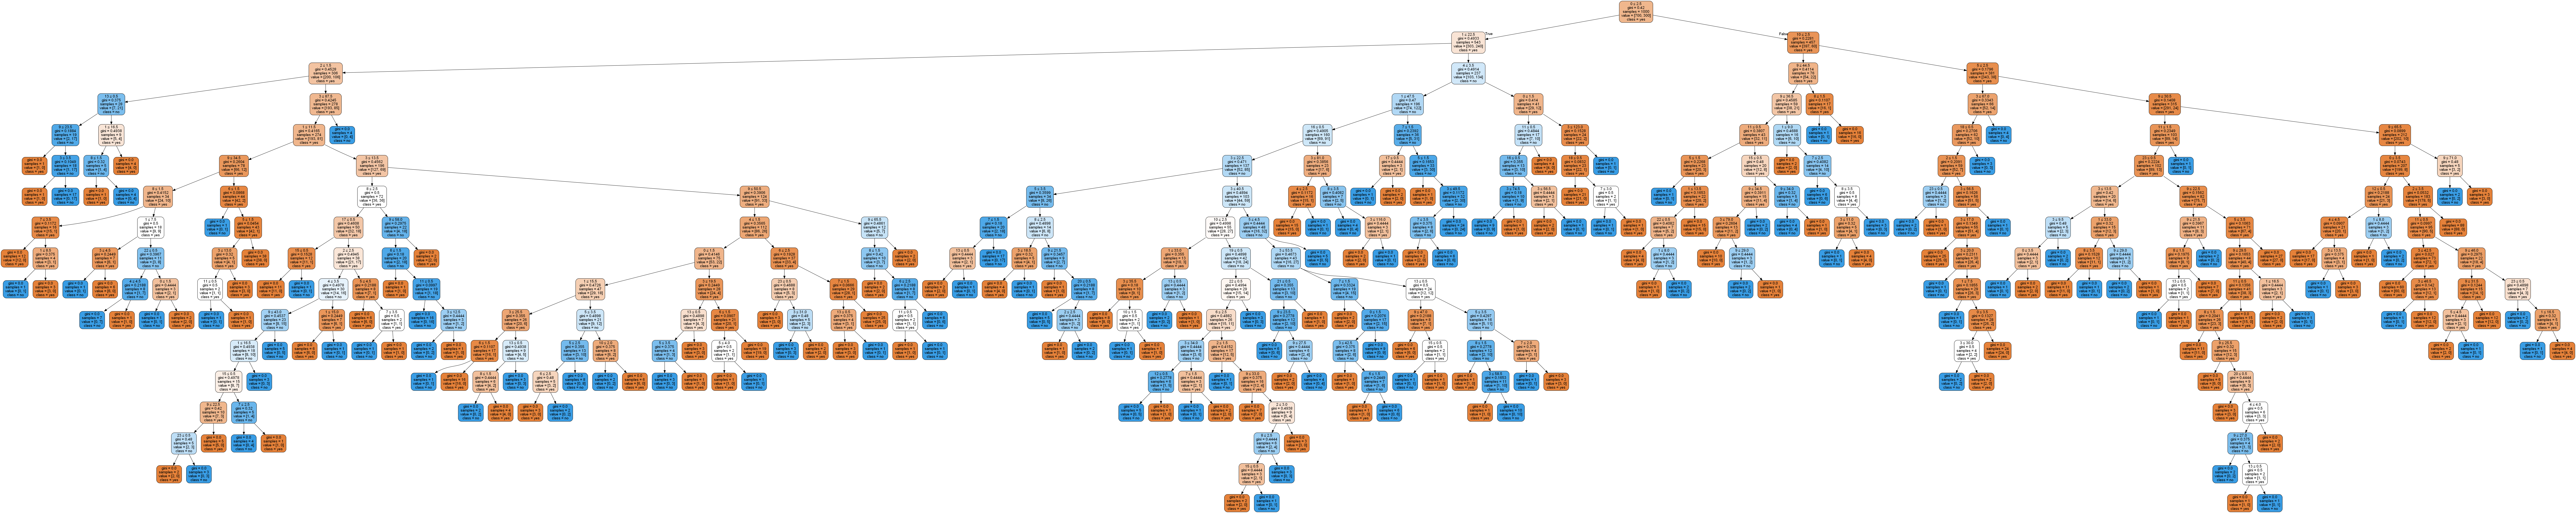

In [93]:
graph = pydotplus.graphviz.graph_from_dot_file("big_tree.out")  
Image(graph.create_png())  

Рассмотрим первые несколько разбиений и попытаемся их проинтерпретировать.

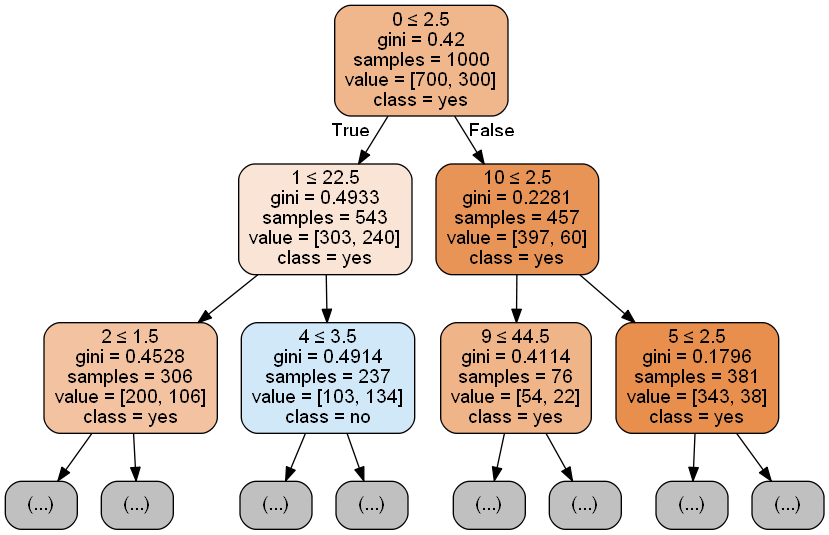

In [94]:
dot_data = tree.export_graphviz(model, out_file="small_tree.out", 
                         feature_names=german_credit_data.feature_names,  
                         class_names=german_credit_data.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True,
                         max_depth=2)
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())  

Для примерного определения признаков пользуемся файлом german.doc.

1-ое разбиение: если у клиента DM < 200 (какое-то значение, связанное с зарплатой), то пока вероятность получить кредит выше и переходим в следующую ветку

2-ое разбиение: если клиент хочет взять кредит менее, чем на 22,5 месяца, то вероятность получить кредит выше и переходим в следующую ветку

3-е разбиение: если размер кредита (что бы это ни значило) менее 3,5, то вероятность получить кредит существенно падает.

...


Теперь строим графики зависимости качества от глубины дерева на кросс-валидации и на тестовой выборке.

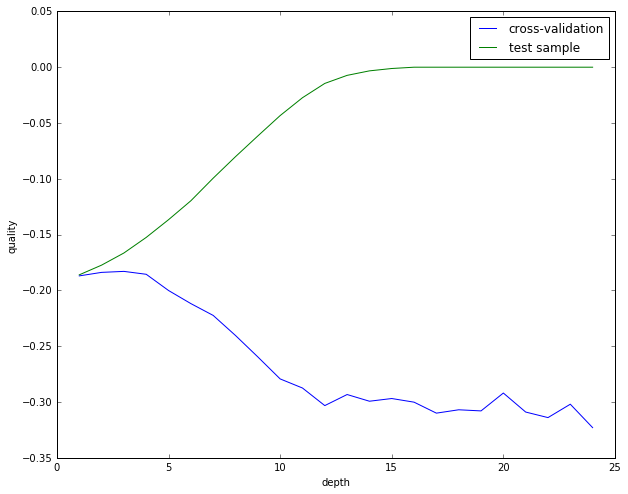

In [153]:
pylab.figure(figsize=(10,8))

depths = range(1, 25)

quality1 = []
for i in depths:
    estimator = DecisionTreeRegressor(max_depth=i)
    quality1.append(np.mean(cross_validation.cross_val_score(estimator, german_credit_data.data, german_credit_data.target,
                                                            scoring='mean_squared_error')))
    
quality2 = []
for i in depths:
    quality2.append(-metrics.mean_squared_error(german_credit_data.target, 
            (DecisionTreeRegressor(max_depth=i).fit(german_credit_data.data, german_credit_data.target)).predict(german_credit_data.data)))

plt.plot(depths, quality1, label="cross-validation")
plt.plot(depths, quality2, label="test sample")

plt.xlabel('depth')
plt.ylabel('quality')

plt.legend()
plt.show()